# Task conception

We have a dataset containing comments and emotions, and we are learning to predict the emotion based on the text of the comment.

# Load + preprocessing

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Step 1: Read the CSV file into a DataFrame
df = pd.read_csv('sample_data/Emotion_classify_Data.csv', sep=',')
df.head(3)


,Comment,Emotion
0,i seriously hate one subject to death but now ...,fear
1,im so full of life i feel appalled,anger
2,i sit here to write i start to dig out my feel...,fear


We assign a unique numeric value to each distinct emotion.

In [4]:
unique_emotions_list = df['Emotion'].unique().tolist()
print(unique_emotions_list)

emotion_mapping = {emotion: idx for idx, emotion in enumerate(unique_emotions_list)}

df['Emotion_Num'] = df['Emotion'].map(emotion_mapping)
df.head(3)

['fear', 'anger', 'joy']


,Comment,Emotion,Emotion_Num
0,i seriously hate one subject to death but now ...,fear,0
1,im so full of life i feel appalled,anger,1
2,i sit here to write i start to dig out my feel...,fear,0


Using ntlk drop stop words.

In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

df['tokenized'] = df['Comment'].str.replace(r'[^a-zA-Z0-9]', ' ', regex=True)  # Keep only letters and digits
#print(data.head(10))
df['tokenized'] = df['tokenized'].str.lower().str.split()  # Lowercase and tokenize
#print(data.head(10))
df['tokenized'] = df['tokenized'].apply(lambda tokens: [word for word in tokens if word not in STOPWORDS])  # Remove stopwords
print(df.head(3))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


                                             Comment Emotion  Emotion_Num  \
0  i seriously hate one subject to death but now ...    fear            0   
1                 im so full of life i feel appalled   anger            1   
2  i sit here to write i start to dig out my feel...    fear            0   

                                           tokenized  
0  [seriously, hate, one, subject, death, feel, r...  
1                   [im, full, life, feel, appalled]  
2  [sit, write, start, dig, feelings, think, afra...  


In [6]:
df.head(3)

,Comment,Emotion,Emotion_Num,tokenized
0,i seriously hate one subject to death but now ...,fear,0,"[seriously, hate, one, subject, death, feel, r..."
1,im so full of life i feel appalled,anger,1,"[im, full, life, feel, appalled]"
2,i sit here to write i start to dig out my feel...,fear,0,"[sit, write, start, dig, feelings, think, afra..."


# TfidfVectorizer + RandomForestClassifier

We transform the set of words from the comments into a TF-IDF matrix.

In [7]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [8]:
df['text'] = df['tokenized'].apply(lambda x: ' '.join(x))
df.head(3)

,Comment,Emotion,Emotion_Num,tokenized,text
0,i seriously hate one subject to death but now ...,fear,0,"[seriously, hate, one, subject, death, feel, r...",seriously hate one subject death feel reluctan...
1,im so full of life i feel appalled,anger,1,"[im, full, life, feel, appalled]",im full life feel appalled
2,i sit here to write i start to dig out my feel...,fear,0,"[sit, write, start, dig, feelings, think, afra...",sit write start dig feelings think afraid acce...


In [9]:
X = df['text']
y = df['Emotion_Num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Then we classify words

In [10]:
vectorizer = TfidfVectorizer()

# Fit and transform the training data, transform the testing data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Initialize a classifier (e.g., Random Forest)
classifier = RandomForestClassifier(random_state=42)

# Train the classifier
classifier.fit(X_train_tfidf, y_train)

# Predict on the test data
y_pred = classifier.predict(X_test_tfidf)

In [11]:
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       416
           1       0.94      0.94      0.94       392
           2       0.93      0.97      0.95       380

    accuracy                           0.95      1188
   macro avg       0.95      0.95      0.95      1188
weighted avg       0.95      0.95      0.95      1188



# Transformer from scratch

In [12]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Convert tokenized lists into text
df['text'] = df['tokenized'].apply(lambda x: ' '.join(x))

# Preprocess data
X = df['text'].tolist()
y = df['Emotion_Num'].tolist()

# Tokenizer: Create a simple vocabulary
vocab = {word: idx for idx, word in enumerate(set(' '.join(X).split()), start=1)}
vocab['<PAD>'] = 0
vocab_size = len(vocab)

def encode_sentence(sentence, vocab, max_len=10):
    tokens = [vocab.get(word, 0) for word in sentence.split()]
    return tokens[:max_len] + [0] * (max_len - len(tokens))

# Encode sentences
max_len = 10
X_encoded = [encode_sentence(sentence, vocab, max_len) for sentence in X]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Create a custom PyTorch Dataset
class EmotionDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = EmotionDataset(X_train, y_train)
test_dataset = EmotionDataset(X_test, y_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

# Transformer Encoder Layer
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = nn.ReLU()

    def forward(self, src):
        src2 = self.self_attn(src, src, src)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

# Transformer Model
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, num_classes, max_len=10):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderLayer(d_model, nhead) for _ in range(num_layers)]
        )
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x) * np.sqrt(x.size(-1))
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # Required for PyTorch's MultiheadAttention
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=0)  # Pooling
        x = self.fc(x)
        return x



In [13]:
# Hyperparameters
#d_model = 128 # accuracy=0.47
#d_model = 64 # accuracy=0.7
d_model = 48 # accuracy=0.77
nhead = 4
num_layers = 2
num_classes = len(set(y))

# Initialize the model, loss, and optimizer
model = TransformerClassifier(vocab_size, d_model, nhead, num_layers, num_classes, max_len)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 11
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        #print(f"Predicted: {predicted.tolist()}, True: {y_batch.tolist()}")
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

print(f"Accuracy: {correct / total:.2f}")


Epoch 1/11, Loss: 1.0798315218373349
Epoch 2/11, Loss: 0.9564592686609218
Epoch 3/11, Loss: 0.8352915437543078
Epoch 4/11, Loss: 0.6748520163678025
Epoch 5/11, Loss: 0.5553431739360094
Epoch 6/11, Loss: 0.4571986316556209
Epoch 7/11, Loss: 0.3751062081360111
Epoch 8/11, Loss: 0.3183480534077573
Epoch 9/11, Loss: 0.27776080122227337
Epoch 10/11, Loss: 0.2396344240951891
Epoch 11/11, Loss: 0.20201763997030886
Accuracy: 0.82


# Improvements for transformer classifier

In [14]:
from torch.optim import AdamW

# Updated Transformer Classifier with Increased Dropout and Attention Pooling
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, num_classes, max_len=10):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderLayer(d_model, nhead, dropout=0.4) for _ in range(num_layers)]  # Increased dropout
        )
        self.attention_pooling = nn.MultiheadAttention(d_model, nhead)  # Attention pooling
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x) * np.sqrt(x.size(-1))
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # Required for PyTorch's MultiheadAttention
        for layer in self.encoder_layers:
            x = layer(x)
        pooled, _ = self.attention_pooling(x, x, x)  # Apply attention pooling
        pooled = pooled.mean(dim=0)  # Pooling
        x = self.fc(pooled)
        return x

# Model
model = TransformerClassifier(vocab_size, d_model, nhead, num_layers, num_classes, max_len)

# Switch to AdamW optimizer
optimizer = AdamW(model.parameters(), lr=0.0001, weight_decay=0.05)

# Add label smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

In [15]:
# Training Loop (unchanged)
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_loader)}")

    # Evaluate after every epoch
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)
    print(f"Epoch {epoch + 1}, Accuracy: {correct / total:.2f}")

Epoch 1/10, Loss: 1.0985615704185083
Epoch 1, Accuracy: 0.42
Epoch 2/10, Loss: 1.0494042880158676
Epoch 2, Accuracy: 0.53
Epoch 3/10, Loss: 0.9344065647878145
Epoch 3, Accuracy: 0.65
Epoch 4/10, Loss: 0.80506421061566
Epoch 4, Accuracy: 0.75
Epoch 5/10, Loss: 0.6853781416165201
Epoch 5, Accuracy: 0.79
Epoch 6/10, Loss: 0.636663021978579
Epoch 6, Accuracy: 0.83
Epoch 7/10, Loss: 0.5839746528550198
Epoch 7, Accuracy: 0.85
Epoch 8/10, Loss: 0.5521488809585571
Epoch 8, Accuracy: 0.86
Epoch 9/10, Loss: 0.5272945979143444
Epoch 9, Accuracy: 0.86
Epoch 10/10, Loss: 0.5085390070990512
Epoch 10, Accuracy: 0.87


# LoRA

In [ ]:
# Define LoRA Layer
import torch
import torch.nn as nn

class LoRALayer(nn.Module):
    def __init__(self, original_dim, rank=4):
        super(LoRALayer, self).__init__()
        self.rank = rank
        # Low-rank matrices A and B
        self.A = nn.Parameter(torch.randn(rank, original_dim) * 0.01)
        self.B = nn.Parameter(torch.randn(original_dim, rank) * 0.01)

    def forward(self, original_weight):
        # Add low-rank update to the original weight
        lora_update = torch.matmul(self.B, self.A)
        return original_weight + lora_update


In [ ]:
# Modify Attention Layer to Use LoRA
class LoRAMultiheadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, rank=4):
        super(LoRAMultiheadAttention, self).__init__()
        self.num_heads = num_heads
        self.embed_dim = embed_dim
        self.rank = rank

        # Original weight matrices for query, key, value
        self.q_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.k_proj = nn.Linear(embed_dim, embed_dim, bias=False)
        self.v_proj = nn.Linear(embed_dim, embed_dim, bias=False)

        # Add LoRA layers for each projection
        self.q_lora = LoRALayer(embed_dim, rank)
        self.k_lora = LoRALayer(embed_dim, rank)
        self.v_lora = LoRALayer(embed_dim, rank)

        self.out_proj = nn.Linear(embed_dim, embed_dim, bias=False)

    def forward(self, query, key, value, attn_mask=None):
        # Apply original projections
        q = self.q_proj(query)
        k = self.k_proj(key)
        v = self.v_proj(value)

        # Add LoRA updates
        q = self.q_lora(q)
        k = self.k_lora(k)
        v = self.v_lora(v)

        # Compute scaled dot-product attention
        attn_weights = torch.matmul(q, k.transpose(-2, -1)) / (self.embed_dim ** 0.5)
        if attn_mask is not None:
            attn_weights += attn_mask
        attn_weights = torch.nn.functional.softmax(attn_weights, dim=-1)
        attn_output = torch.matmul(attn_weights, v)

        # Output projection
        return self.out_proj(attn_output)


In [ ]:
# Update the Transformer Encoder
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, rank=4, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = LoRAMultiheadAttention(embed_dim, num_heads, rank)

        self.linear1 = nn.Linear(embed_dim, embed_dim * 4)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(embed_dim * 4, embed_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        # Self-attention with LoRA
        src2 = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)

        # Feedforward network
        src2 = self.linear2(self.dropout(torch.nn.functional.relu(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)

        return src


In [ ]:
# Modify the Transformer Classifier
class TransformerClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, num_layers, num_classes, max_len=10, rank=4):
        super(TransformerClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.pos_encoder = PositionalEncoding(embed_dim, max_len)
        self.encoder_layers = nn.ModuleList(
            [TransformerEncoderLayer(embed_dim, num_heads, rank) for _ in range(num_layers)]
        )
        self.fc = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x) * (x.size(-1) ** 0.5)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)  # Transpose for attention layers
        for layer in self.encoder_layers:
            x = layer(x)
        x = x.mean(dim=0)  # Pooling
        return self.fc(x)


In [ ]:

# Integrate LoRA
from peft import get_peft_model, LoraConfig, TaskType

model = TransformerClassifier(vocab_size, d_model, nhead, num_layers, num_classes, max_len)

# Configure LoRA for fine-tuning
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS, # Task type: sequence classification
    inference_mode=False,
    r=16, # LoRA rank
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=[
        "encoder_layers.0.linear1",
        "encoder_layers.0.linear2",
        "encoder_layers.1.linear1",
        "encoder_layers.1.linear2",
        "fc",  # Include final classification layer
    ],
)

for name, _ in model.named_modules():
    print(name)

# Wrap the model with LoRA
model = get_peft_model(model, lora_config)
print("LoRA model is ready.")


# Ensure LoRA parameters are trainable
'''for name, param in model.named_parameters():
    if "lora" in name:
        param.requires_grad = True'''

# Optimizer setup for LoRA parameters only
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
print("Optimizer initialized for LoRA parameters.")

# Train LoRA Parameters Only
# Freeze all parameters except LoRA layers
for name, param in model.named_parameters():
    #
    if "A" in name or "B" in name:
        param.requires_grad = True
    else:
        param.requires_grad = False
    #print(name,param.requires_grad)




embedding
pos_encoder
encoder_layers
encoder_layers.0
encoder_layers.0.self_attn
encoder_layers.0.self_attn.q_proj
encoder_layers.0.self_attn.k_proj
encoder_layers.0.self_attn.v_proj
encoder_layers.0.self_attn.q_lora
encoder_layers.0.self_attn.k_lora
encoder_layers.0.self_attn.v_lora
encoder_layers.0.self_attn.out_proj
encoder_layers.0.linear1
encoder_layers.0.dropout
encoder_layers.0.linear2
encoder_layers.0.norm1
encoder_layers.0.norm2
encoder_layers.0.dropout1
encoder_layers.0.dropout2
encoder_layers.1
encoder_layers.1.self_attn
encoder_layers.1.self_attn.q_proj
encoder_layers.1.self_attn.k_proj
encoder_layers.1.self_attn.v_proj
encoder_layers.1.self_attn.q_lora
encoder_layers.1.self_attn.k_lora
encoder_layers.1.self_attn.v_lora
encoder_layers.1.self_attn.out_proj
encoder_layers.1.linear1
encoder_layers.1.dropout
encoder_layers.1.linear2
encoder_layers.1.norm1
encoder_layers.1.norm2
encoder_layers.1.dropout1
encoder_layers.1.dropout2
fc
LoRA model is ready.
Optimizer initialized fo

In [ ]:
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import get_scheduler

# Define loss and optimizer
loss_fn = CrossEntropyLoss()
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

# Define learning rate scheduler
num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

# Move model to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)


PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): TransformerClassifier(
      (embedding): Embedding(8835, 48)
      (pos_encoder): PositionalEncoding()
      (encoder_layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): LoRAMultiheadAttention(
            (q_proj): Linear(in_features=48, out_features=48, bias=False)
            (k_proj): Linear(in_features=48, out_features=48, bias=False)
            (v_proj): Linear(in_features=48, out_features=48, bias=False)
            (q_lora): LoRALayer()
            (k_lora): LoRALayer()
            (v_lora): LoRALayer()
            (out_proj): Linear(in_features=48, out_features=48, bias=False)
          )
          (linear1): lora.Linear(
            (base_layer): Linear(in_features=48, out_features=192, bias=True)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.1, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): L

In [ ]:
print(len(train_loader))

2375


In [ ]:
from tqdm import tqdm
print(len(train_loader))

for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        print('type:',type(batch))
        print(batch)

        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            val_loss += loss.item()

            preds = torch.argmax(outputs.logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    accuracy = correct / total
    print(f"Validation Loss: {avg_val_loss}, Accuracy: {accuracy:.4f}")

# MLflow

In [16]:
! pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 114.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 23.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.0/623.0 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00


In [17]:
import mlflow
import mlflow.pytorch

# Start an MLflow run
mlflow.set_experiment("Emotion Classification with Transformer")
with mlflow.start_run(run_name="Transformer_Classifier"):
    # Log parameters
    mlflow.log_param("vocab_size", vocab_size)
    mlflow.log_param("d_model", d_model)
    mlflow.log_param("nhead", nhead)
    mlflow.log_param("num_layers", num_layers)
    mlflow.log_param("num_classes", num_classes)
    mlflow.log_param("max_len", max_len)
    mlflow.log_param("optimizer", "AdamW")
    mlflow.log_param("learning_rate", 0.0001)
    mlflow.log_param("weight_decay", 0.05)
    mlflow.log_param("label_smoothing", 0.1)

    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss}")
        mlflow.log_metric("train_loss", avg_loss, step=epoch)

        # Evaluate after every epoch
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)
        accuracy = correct / total
        print(f"Epoch {epoch + 1}, Accuracy: {accuracy:.2f}")
        mlflow.log_metric("accuracy", accuracy, step=epoch)

    # Log the final model
    mlflow.pytorch.log_model(model, "model")
    print("Model logged in MLflow")


2024/12/16 20:19:34 INFO mlflow.tracking.fluent: Experiment with name 'Emotion Classification with Transformer' does not exist. Creating a new experiment.


Epoch 1/10, Loss: 0.49182165778310677
Epoch 1, Accuracy: 0.87
Epoch 2/10, Loss: 0.4770316896187632
Epoch 2, Accuracy: 0.87
Epoch 3/10, Loss: 0.46347605361436545
Epoch 3, Accuracy: 0.87
Epoch 4/10, Loss: 0.4472038421505376
Epoch 4, Accuracy: 0.86
Epoch 5/10, Loss: 0.4431534963783465
Epoch 5, Accuracy: 0.87
Epoch 6/10, Loss: 0.4269520337958085
Epoch 6, Accuracy: 0.87
Epoch 7/10, Loss: 0.42373635873041654
Epoch 7, Accuracy: 0.87
Epoch 8/10, Loss: 0.4100587302509107
Epoch 8, Accuracy: 0.87
Epoch 9/10, Loss: 0.4123604295002787
Epoch 9, Accuracy: 0.88
Epoch 10/10, Loss: 0.4047422114422447


2024/12/16 20:25:44 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


Epoch 10, Accuracy: 0.86


2024/12/16 20:25:53 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/16 20:25:53 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Model logged in MLflow


# A/B tests

In [21]:
# Define two configurations for A/B testing
configs = {
    "Variant_A": {"d_model": 48, "nhead": 4, "num_layers": 2, "learning_rate": 0.001},
    "Variant_B": {"d_model": 64, "nhead": 8, "num_layers": 3, "learning_rate": 0.0005},
}

# Perform A/B tests
for variant, params in configs.items():
    with mlflow.start_run(run_name=variant):
        # Log parameters
        mlflow.log_params(params)
        mlflow.log_param("optimizer", "AdamW")
        mlflow.log_param("weight_decay", 0.05)
        mlflow.log_param("label_smoothing", 0.1)

        # Initialize model
        model = TransformerClassifier(
            vocab_size=vocab_size,
            d_model=params["d_model"],
            nhead=params["nhead"],
            num_layers=params["num_layers"],
            num_classes=num_classes,
            max_len=max_len
        )
        optimizer = AdamW(model.parameters(), lr=params["learning_rate"], weight_decay=0.05)

        # Training loop
        for epoch in range(num_epochs):
            model.train()
            total_loss = 0
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                output = model(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()
            avg_loss = total_loss / len(train_loader)
            mlflow.log_metric("train_loss", avg_loss, step=epoch)

            # Evaluation
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for X_batch, y_batch in test_loader:
                    outputs = model(X_batch)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == y_batch).sum().item()
                    total += y_batch.size(0)
            accuracy = correct / total
            mlflow.log_metric("accuracy", accuracy, step=epoch)

        # Log the final model
        mlflow.pytorch.log_model(model, "model")
        print(f"{variant} completed: Model logged to MLflow.")



2024/12/16 20:34:02 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/16 20:34:06 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/16 20:34:06 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Variant_A completed: Model logged to MLflow.


2024/12/16 20:44:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/16 20:44:20 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2024/12/16 20:44:20 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Variant_B completed: Model logged to MLflow.


# Models Comparison

In [32]:
import mlflow
from mlflow.tracking import MlflowClient

client = MlflowClient()

# Get experiments
experiment = client.get_experiment_by_name("Emotion Classification with Transformer")

# Fetch runs
runs = client.search_runs(experiment.experiment_id, order_by=["metrics.accuracy DESC"])

print("Top Model Comparisons:")
for run in runs[:5]:
    print(f"Run ID: {run.info.run_id}")
    print(f"Params: {run.data.params}")
    print(f"Metrics: {run.data.metrics}")
    print("-" * 30)


Top Model Comparisons:
Run ID: 765ee34c3a6e4b969911e0da05d36354
Params: {'vocab_size': '8835', 'nhead': '4', 'label_smoothing': '0.1', 'max_len': '10', 'num_classes': '3', 'num_layers': '2', 'weight_decay': '0.05', 'learning_rate': '0.0001', 'd_model': '48', 'optimizer': 'AdamW'}
Metrics: {'accuracy': 0.8594276094276094, 'train_loss': 0.4047422114422447}
------------------------------
Run ID: 7a0e4710f62149f2a4708c8d799593ce
Params: {'nhead': '4', 'label_smoothing': '0.1', 'num_layers': '2', 'weight_decay': '0.05', 'learning_rate': '0.001', 'd_model': '48', 'optimizer': 'AdamW'}
Metrics: {'accuracy': 0.6111111111111112, 'train_loss': 0.7402817057308397}
------------------------------
Run ID: 10bb2512ac38455da7592bd5c0b0e95b
Params: {'nhead': '8', 'label_smoothing': '0.1', 'num_layers': '3', 'weight_decay': '0.05', 'learning_rate': '0.0005', 'd_model': '64', 'optimizer': 'AdamW'}
Metrics: {'accuracy': 0.31986531986531985, 'train_loss': 1.09865632443679}
------------------------------
Ru

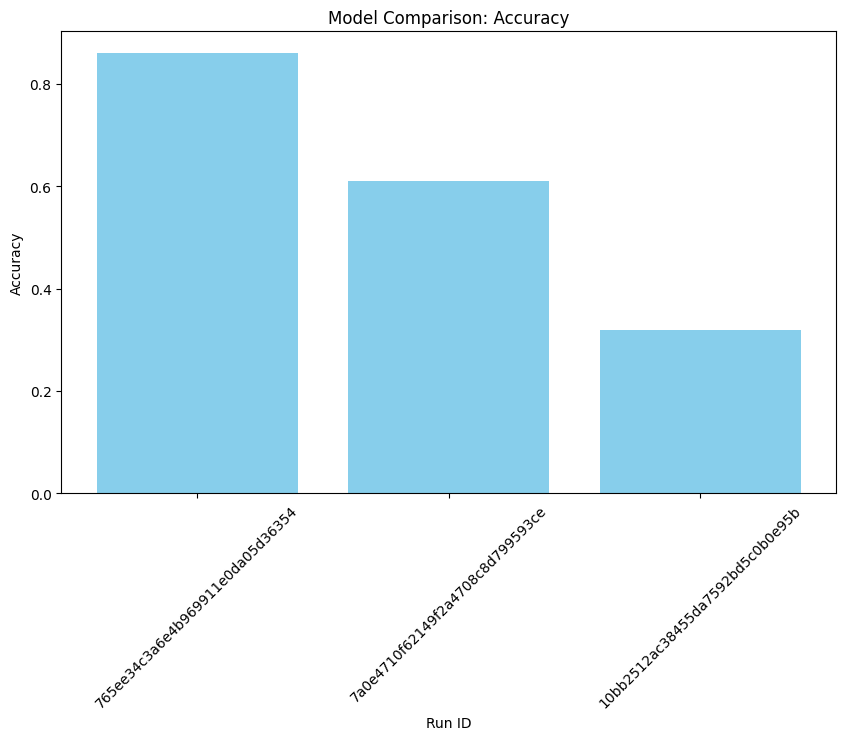

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Fetch run data into a DataFrame
data = []
for run in runs:
    metrics = run.data.metrics
    params = run.data.params
    data.append({**metrics, **params, "run_id": run.info.run_id})

df = pd.DataFrame(data)

# Plot accuracy for each variant
plt.figure(figsize=(10, 6))
plt.bar(df["run_id"], df["accuracy"], color="skyblue")
plt.title("Model Comparison: Accuracy")
plt.xlabel("Run ID")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()
